# Deep Recurrent Q-Network (DRQN) for Leduc Hold'em

**Author:** Lead ML Engineer  
**Date:** 2026-02-03  

## Overview
This notebook implements an adaptive Reinforcement Learning agent for Leduc Hold'em using **RLCard** and **PyTorch**. We utilize a **Deep Recurrent Q-Network (DRQN)** architecture to handle the partial observability of Poker. Unlike standard DQN which assumes states are independent (Markov property), DRQN utilizes an **LSTM (Long Short-Term Memory)** layer to maintain an internal belief state (hidden state) summarizing the history of the hand (bets, raises, public cards).

### Core Components:
1.  **Environment**: `leduc-holdem` via RLCard.
2.  **Model**: `DRQN` with LSTM memory and dual processing heads (State & History).
3.  **Memory**: `SequenceReplayBuffer` storing full game episodes.
4.  **Training**: Adaptive loop against specific personalities ('Maniac', 'Nit').


In [ ]:
# Cell 1: Setup & Installation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import rlcard
from rlcard.agents import RandomAgent
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Sequence Replay Buffer

Standard DQN buffers store transitions `(s, a, r, s', done)`. For DRQN, we need to train the LSTM on sequences of events to allow it to learn temporal dependencies (e.g., "Opponent raised twice in a row").

We store **Episodes**: complete sequences of a hand from start to finish. When sampling, we pad shorter episodes to match the length of the longest episode in the batch.

In [ ]:
# Cell 2: Sequence Replay Buffer

class SequenceReplayBuffer:
    def __init__(self, capacity, action_dim=3):
        self.buffer = deque(maxlen=capacity)
        self.action_dim = action_dim

    def push(self, episode):
        """
        Stores a full episode.
        Episode format: List of transitions [(state, action, reward, next_state, done, legal_actions), ...]
        """
        self.buffer.append(episode)

    def sample(self, batch_size):
        """
        Samples a batch of episodes and pads them to the same length.
        Returns tensor batches for states, actions, rewards, etc.
        """
        batch = random.sample(self.buffer, batch_size)
        
        # Sort by length for efficient packing (optional, but good practice)
        batch.sort(key=lambda x: len(x), reverse=True)
        
        lengths = [len(x) for x in batch]
        max_len = max(lengths)

        # Unzip batch data
        # We need to pad sequences. 0 is used for padding.
        # States dim: (batch, seq_len, state_dim)
        state_dim = batch[0][0][0].shape[0]
        
        states_padded = torch.zeros(batch_size, max_len, state_dim)
        actions_padded = torch.zeros(batch_size, max_len).long()
        rewards_padded = torch.zeros(batch_size, max_len)
        next_states_padded = torch.zeros(batch_size, max_len, state_dim)
        dones_padded = torch.zeros(batch_size, max_len)
        # Use self.action_dim to ensure the mask is large enough
        legal_actions_mask = torch.zeros(batch_size, max_len, self.action_dim)

        for i, episode in enumerate(batch):
            seq_len = len(episode)
            for t, transition in enumerate(episode):
                s, a, r, ns, d, la = transition
                
                states_padded[i, t] = torch.FloatTensor(s)
                actions_padded[i, t] = a
                rewards_padded[i, t] = r
                next_states_padded[i, t] = torch.FloatTensor(ns)
                dones_padded[i, t] = float(d)
                
                # Create legal action mask (1 for legal, 0 for illegal)
                for action_idx in la:
                    if action_idx < self.action_dim:
                        legal_actions_mask[i, t, action_idx] = 1.0

        return (
            states_padded.to(device), 
            actions_padded.to(device), 
            rewards_padded.to(device), 
            next_states_padded.to(device), 
            dones_padded.to(device), 
            legal_actions_mask.to(device),
            lengths
        )

## 3. DRQN Architecture

### The "Why" of LSTM in Poker
Poker is a game of **imperfect information**. A single snapshot of the table (cards + chips) does not tell the full story. The *sequence* of betting actions carries information about the opponent's hidden cards. 

- **Standard Feed-Forward Network**: $Q(s)$ - Treats state as isolated.
- **Recurrent Network**: $Q(h_t)$, where $h_t = LSTM(s_t, h_{t-1})$. The hidden state $h_t$ acts as a memory, aggregating the history of aggression, hesitation, or patterns.

We implement a model with two conceptual "heads" or processing streams merged before the LSTM:
1.  **State Processing**: Handling raw card/chip information.
2.  **Sequence Processing**: The LSTM itself naturally processes the history.

The output is Q-values for all actions.

In [ ]:
# Cell 3: The LSTM PyTorch Model

class DRQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(DRQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Feature Extractor (Head 1: State Processing)
        # Processes the immediate state vector into a dense representation
        self.fc_feat = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # LSTM Core (Head 2: History/Sequence Processing)
        # Takes the feature sequence and maintains memory
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Q-Value Head
        # Maps LSTM output to action values
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.size()
        
        # 1. Process features for every step in the sequence
        # Flatten to pass through FC layers: (batch*seq, input_dim)
        x_flat = x.view(-1, x.size(2))
        features = self.fc_feat(x_flat)
        
        # Reshape back to sequence: (batch, seq, feature_dim)
        features = features.view(batch_size, seq_len, -1)
        
        # 2. Pass through LSTM
        # If hidden is None, it defaults to 0
        lstm_out, new_hidden = self.lstm(features, hidden)
        
        # 3. Calculate Q-values
        q_values = self.fc_out(lstm_out)
        
        return q_values, new_hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

## 4. Training Utilities and Agent Wrapper

We define the `DRQNAgent` to handle the interaction logic. Crucially, it must:
1.  **Maintain Hidden State**: Reset at the start of a game, update at every step.
2.  **Epsilon-Greedy**: Balance exploration and exploitation.
3.  **Action Masking**: Never choose illegal moves (e.g., folding when checking is free).

In [ ]:
# Cell 4: Utility functions and Agent Wrapper

class DRQNAgent:
    def __init__(self, input_dim, output_dim, hidden_dim=128, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        self.model = DRQN(input_dim, hidden_dim, output_dim).to(device)
        self.target_model = DRQN(input_dim, hidden_dim, output_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.output_dim = output_dim
        
        # Inference state tracking
        self.reset_hidden()

    def reset_hidden(self):
        self.current_hidden = None # Will be auto-initialized in forward

    def select_action(self, state, legal_actions, eval_mode=False):
        # Epsilon-greedy
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)

        # Prepare state tensor: (1, 1, state_dim) -> Batch=1, Seq=1
        state_t = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values, self.current_hidden = self.model(state_t, self.current_hidden)
            
        # Mask illegal actions
        q_values = q_values[0, 0].cpu().numpy()
        masked_q_values = -np.inf * np.ones(self.output_dim)
        masked_q_values[legal_actions] = q_values[legal_actions]
        
        return np.argmax(masked_q_values)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
    def train_step(self, buffer, batch_size):
        if len(buffer.buffer) < batch_size:
            return None
            
        states, actions, rewards, next_states, dones, mask, lengths = buffer.sample(batch_size)
        
        # 1. Forward pass for current states
        # We process the whole sequence at once
        q_values, _ = self.model(states)
        
        # Gather Q-values for taken actions: (batch, seq, 1)
        q_pred = q_values.gather(2, actions.unsqueeze(2)).squeeze(2)
        
        # 2. Forward pass for target (next states)
        with torch.no_grad():
            target_q_values, _ = self.target_model(next_states)
            # Double DQN could be implemented here, simple Max for now
            max_target_q, _ = target_q_values.max(dim=2)
        
        # 3. Calculate Target
        target = rewards + self.gamma * max_target_q * (1 - dones)
        
        # 4. Loss Calculation
        # We only care about loss for valid time steps (not padding)
        loss = F.mse_loss(q_pred, target, reduction='none')
        
        # Mask padding
        seq_mask = torch.zeros_like(loss)
        for i, length in enumerate(lengths):
            seq_mask[i, :length] = 1.0
            
        loss = (loss * seq_mask).sum() / seq_mask.sum()
        
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for LSTM stability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()

## 5. Opponent Modeling & Training Loop

To demonstrate adaptation, we create two fixed-strategy opponents:
1.  **Maniac**: Always Raises if possible, otherwise Calls.
2.  **Nit**: Always Folds if raised against, acts conservatively.

We will train against one, then switch, or mix them to see if the DRQN can identify the current opponent via the history.

In [ ]:
# Cell 5: Training Loop

# --- Fixed Opponents ---
class ManiacAgent:
    def __init__(self, action_num):
        self.use_raw = False
        self.action_num = action_num
    def step(self, state):
        legal_actions = list(state['legal_actions'].keys())
        # 1 is usually raise in leduc (0: Call, 1: Raise, 2: Fold)
        if 1 in legal_actions:
            return 1
        return 0 # Call
    def eval_step(self, state):
        return self.step(state), {}

class NitAgent:
    def __init__(self, action_num):
        self.use_raw = False
        self.action_num = action_num
    def step(self, state):
        legal_actions = list(state['legal_actions'].keys())
        # If facing a raise (usually implied if check isn't an option?), fold
        # Simplification: If can fold, fold. If can only check/call, check.
        if 2 in legal_actions: # Fold
            return 2
        return 0 # Check/Call
    def eval_step(self, state):
        return self.step(state), {}

# --- Training Configuration ---
env = rlcard.make('leduc-holdem', config={'seed': SEED})
input_dim = env.state_shape[0][0]
output_dim = env.num_actions

agent = DRQNAgent(input_dim, output_dim)
# PASSING action_dim=output_dim TO FIX INDEXERROR
buffer = SequenceReplayBuffer(capacity=5000, action_dim=output_dim)
opponents = [ManiacAgent(output_dim), NitAgent(output_dim)]
current_opponent = opponents[0]

num_episodes = 2000
batch_size = 32
target_update_freq = 100
rewards_history = []
loss_history = []

print("Starting training...")

for episode in range(num_episodes):
    # Switch opponent halfway to test adaptation
    if episode == num_episodes // 2:
        print(f"\n--- SWITCHING OPPONENT to Nit (Episode {episode}) ---")
        current_opponent = opponents[1]
        
    # Set agents: [Our Agent, Opponent]
    env.set_agents([agent, current_opponent])
    
    state, player_id = env.reset()
    agent.reset_hidden() # New episode, new memory
    
    episode_transitions = []
    cumulative_reward = 0
    
    while not env.is_over():
        # Only act if it's our turn
        if player_id == agent.player_id if hasattr(agent, 'player_id') else 0: 
            # (RLCard handles turn switching, we just need to know if we act)
            # Note: in RLCard loop, we usually step the env and it returns state for the NEXT player.
            # We need to construct the loop carefully or use the provided traverse/step API.
            pass
        
        # RLCard native loop wrapper is cleaner, let's implement the step-by-step manually
        # to ensure we capture the sequence correctly for the DRQN.
        
        # However, RLCard's env.run() or env.step() logic is specific.
        # We'll use a standard loop logic tailored for self-play collection.
        
        # --- Manual Gameplay Loop for Sequence Collection ---
        state, player_id = env.reset()
        agent.reset_hidden()
        done = False
        
        # Temporary buffer for the current trajectory
        traj = []
        
        while not done:
            if player_id == 0: # Our Agent
                raw_obs = state['obs']
                legal_actions = list(state['legal_actions'].keys())
                
                action = agent.select_action(raw_obs, legal_actions)
                
                # Store transition info temporarily
                # We don't know next_state or reward yet
                traj.append({
                    'state': raw_obs,
                    'action': action,
                    'legal_actions': legal_actions
                })
                
                next_state, next_player_id = env.step(action)
            else:
                # Opponent turn
                action, _ = current_opponent.eval_step(state)
                next_state, next_player_id = env.step(action)
            
            state = next_state
            player_id = next_player_id
            done = env.is_over()
            
    # --- Post-Episode Processing ---
    # Assign rewards to the trajectory steps
    # RLCard returns final payoffs for all players
    payoffs = env.get_payoffs()
    agent_payoff = payoffs[0]
    
    cumulative_reward = agent_payoff
    rewards_history.append(agent_payoff)
    
    # Construct the sequence for the buffer
    # (s, a, r, s', done, legal_actions)
    formatted_episode = []
    for i, step_data in enumerate(traj):
        s = step_data['state']
        a = step_data['action']
        la = step_data['legal_actions']
        
        # Reward is usually 0 until the end in Poker, or we can shape it.
        # We use terminal reward at the last step, 0 otherwise.
        r = agent_payoff if i == len(traj) - 1 else 0
        d = True if i == len(traj) - 1 else False
        
        # Next state: In DRQN, next state is the state at t+1 in the sequence.
        # Note: If the opponent moves between our moves, 'next_state' from our perspective
        # is the state when we get the turn back.
        if i < len(traj) - 1:
            ns = traj[i+1]['state']
        else:
            # Terminal state (dummy)
            ns = np.zeros_like(s)
            
        formatted_episode.append((s, a, r, ns, d, la))
    
    buffer.push(formatted_episode)
    
    # Update Agent
    if len(buffer.buffer) > batch_size:
        loss = agent.train_step(buffer, batch_size)
        if loss:
            loss_history.append(loss)
            
    # Target Network Update
    if episode % target_update_freq == 0:
        agent.target_model.load_state_dict(agent.model.state_dict())
    
    agent.update_epsilon()
    
    if episode % 100 == 0:
        avg_rew = np.mean(rewards_history[-100:])
        print(f"Episode {episode} | Avg Reward (last 100): {avg_rew:.3f} | Epsilon: {agent.epsilon:.3f}")

Starting training...
Episode 0 | Avg Reward (last 100): -2.000 | Epsilon: 0.995
Episode 100 | Avg Reward (last 100): -0.725 | Epsilon: 0.603
Episode 200 | Avg Reward (last 100): -0.870 | Epsilon: 0.365
Episode 300 | Avg Reward (last 100): 0.000 | Epsilon: 0.221
Episode 400 | Avg Reward (last 100): -0.330 | Epsilon: 0.134
Episode 500 | Avg Reward (last 100): 0.365 | Epsilon: 0.100
Episode 600 | Avg Reward (last 100): -0.655 | Epsilon: 0.100
Episode 700 | Avg Reward (last 100): 0.240 | Epsilon: 0.100
Episode 800 | Avg Reward (last 100): 0.030 | Epsilon: 0.100
Episode 900 | Avg Reward (last 100): 0.500 | Epsilon: 0.100

--- SWITCHING OPPONENT to Nit (Episode 1000) ---
Episode 1000 | Avg Reward (last 100): 0.185 | Epsilon: 0.100
Episode 1100 | Avg Reward (last 100): 0.710 | Epsilon: 0.100
Episode 1200 | Avg Reward (last 100): 0.770 | Epsilon: 0.100
Episode 1300 | Avg Reward (last 100): 0.750 | Epsilon: 0.100
Episode 1400 | Avg Reward (last 100): 0.690 | Epsilon: 0.100
Episode 1500 | Avg Re

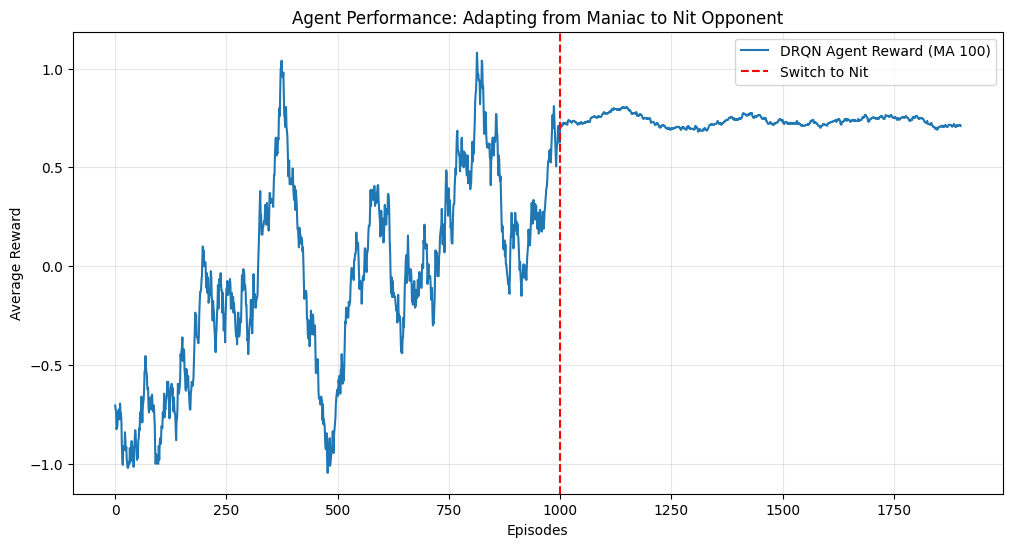

In [ ]:
# Cell 6: Visualization

def moving_average(a, n=50):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(12, 6))
ma_rewards = moving_average(rewards_history, n=100)
plt.plot(ma_rewards, label='DRQN Agent Reward (MA 100)')
plt.axvline(x=num_episodes // 2, color='r', linestyle='--', label='Switch to Nit')
plt.title('Agent Performance: Adapting from Maniac to Nit Opponent')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 7: Play against the Bot!
# Run this cell to play a game against your trained DRQN agent.

def print_state(state, player_id):
    print(f"\n--- Player {player_id}'s Turn ---")
    raw = state['raw_obs']
    print(f"Your Hand: {raw['hand']}")
    print(f"Public Card: {raw['public_card'] if raw['public_card'] else 'None'}")
    print(f"Chips: {raw['my_chips']} (You) vs {raw['all_chips'][1-player_id]} (Bot)")
    print(f"Legal Actions: {list(state['legal_actions'].keys())}")
    # Map actions: 0: Call/Check, 1: Raise, 2: Fold
    action_map = {0: 'Call/Check', 1: 'Raise', 2: 'Fold'}
    actions_str = ", ".join([f"{k}: {action_map.get(k, k)}" for k in state['legal_actions'].keys()])
    print(f"Actions: {actions_str}")

def play_game(agent):
    env = rlcard.make('leduc-holdem', config={'seed': 42})
    # Human is Player 1, Bot is Player 0
    
    print("\n=== NEW GAME VS DRQN BOT ===")
    state, player_id = env.reset()
    agent.reset_hidden()
    
    while not env.is_over():
        current_player = player_id
        
        if current_player == 0:
            # Bot Turn
            print("\n[Bot is thinking...]")
            raw_obs = state['obs']
            legal_actions = list(state['legal_actions'].keys())
            
            # Eval mode = True
            action = agent.select_action(raw_obs, legal_actions, eval_mode=True)
            
            action_strs = ['Call/Check', 'Raise', 'Fold']
            if action < len(action_strs):
                action_str = action_strs[action]
            else:
                action_str = str(action)
            print(f"Bot chooses: {action_str}")
            
            state, player_id = env.step(action)
            
        else:
            # Human Turn
            print_state(state, current_player)
            legal_actions = list(state['legal_actions'].keys())
            
            while True:
                try:
                    user_input = input("Enter your action (0, 1, or 2): ")
                    action = int(user_input)
                    if action in legal_actions:
                        break
                    else:
                        print(f"Invalid action! Choose from {legal_actions}")
                except ValueError:
                    print("Please enter a number.")
            
            state, player_id = env.step(action)

    # Game Over
    payoffs = env.get_payoffs()
    print("\n=== GAME OVER ===")
    print(f"Bot Payoff: {payoffs[0]}")
    print(f"Your Payoff: {payoffs[1]}")
    if payoffs[1] > 0:
        print("You Win! 🎉")
    elif payoffs[1] < 0:
        print("Bot Wins! 🤖")
    else:
        print("Draw! 🤝")

# Start a game
try:
    while True:
        play_game(agent)
        again = input("\nPlay again? (y/n): ")
        if again.lower() != 'y':
            break
except KeyboardInterrupt:
    print("\nGame exited.")



=== NEW GAME VS DRQN BOT ===

--- Player 1's Turn ---
Your Hand: HJ
Public Card: None
Chips: 1 (You) vs 2 (Bot)
Legal Actions: [0, 1, 2]
Actions: 0: Call/Check, 1: Raise, 2: Fold

[Bot is thinking...]
Bot chooses: Raise

--- Player 1's Turn ---
Your Hand: HJ
Public Card: None
Chips: 2 (You) vs 4 (Bot)
Legal Actions: [0, 1, 2]
Actions: 0: Call/Check, 1: Raise, 2: Fold

[Bot is thinking...]
Bot chooses: Raise

--- Player 1's Turn ---
Your Hand: HJ
Public Card: SK
Chips: 4 (You) vs 8 (Bot)
Legal Actions: [0, 1, 2]
Actions: 0: Call/Check, 1: Raise, 2: Fold

=== GAME OVER ===
Bot Payoff: 4.0
Your Payoff: -4.0
Bot Wins! 🤖
